In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import KMeans
import OptimalK
from transformers import AutoTokenizer, AutoModel
import umap
import plotly.express as px
import re

'''
TODO: Visualize which MDS are most likely to be mixed up

'''

'\nTODO: Visualize which MDS are most likely to be mixed up\n\n'

In [898]:
def GetCategoriesSum(df, category_name: str):
    category = dict()

    for entry in df[category_name]:
        if pd.isnull(entry):
            continue  

        items = entry.split(',')
        for item in items:
            item = item.strip() 
            if item:  
                if item in category:
                    category[item] += 1
                else:
                    category[item] = 1
                    
    return category


def EmbedFrame(df, category_name: str, model: SentenceTransformer):
    embeddings = model.encode(df[category_name].tolist())
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) 
    return embeddings


def CreateCluster(df, embeddings, num_clusters, title):

    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(embeddings)
    cluster_assignments = clustering_model.labels_

    for sentence_id, cluster_id in enumerate(cluster_assignments):
        df.loc[sentence_id, title] = cluster_id


def PrintCluster(cluster):
    for cluster_id, mds_list in cluster.items():
        print(f"\nCluster {cluster_id}:")
        print("-" * 20)
        for mds in mds_list:
            print(f"- {mds}")

def ReduceEmbedding(embedded_text, neighbors=100, min_distance=0.0):
    reducer = umap.UMAP(n_neighbors=neighbors, n_components=2, random_state=42, min_dist=min_distance)
    return reducer.fit_transform(embedded_text)
    
def VisualizeCluster(df, graph_title, reduced_embeddings, cluster_title: str, category: str = "MDS Simplified", show_authors=False, show_country=False, show_sample_size=False, show_patient_count=False, show_control_count=False, show_year=False, show_data_source=False, show_algorithm=False, show_task=False, show_cv=False, show_performance_metric=False, show_dataset=False, show_goal=False, show_wearable=False):
    df[category] = df[category].str.strip().str.upper()
    #Authors	Year	Paper	Country	MDS	Data Source Primary	Data Source Secondary	Algorithm	Task	Cross Validation	Performance Metric	Sample Size	Dataset	Goal	Abstract	Person	Notes	Wearable Location
    plot_df = pd.DataFrame({
        'UMAP1': reduced_embeddings[:, 0],
        'UMAP2': reduced_embeddings[:, 1],
        'MDS Simplified': df[category],
        'Paper': df['Paper'], 
        'MDS': df['MDS'],
        cluster_title: df[cluster_title].astype(str),
        "Authors": df["Authors"],
        "Country": df["Country"],
        "Sample Size": df["Sample Size"],
        "Patient Count": df["Patient Count"],
        "Control Count": df["Control Count"],
        "Year": df["Year"],
        "Data Source Secondary": df["Data Source Secondary"],
        "Algorithm" : df["Algorithm"],
        "Task": df["Task"],
        "CV" : df["Cross Validation"],
        "Performance Metric": df["Performance Metric"],
        "Dataset": df["Dataset"],
        "Goal": df["Goal"],
        "Wearable": df["Wearable Location"]


    })
    
    symbol_map = {
        '0.0': 'circle',
        '1.0': 'square',
        '2.0': 'diamond',
        '3.0': 'triangle-up',
        '4.0': 'star',
        '5.0': 'bowtie',
        '6.0': 'pentagon',
        '7.0': 'triangle-left',
        '8.0': 'diamond-cross',
        '9.0': 'triangle-down',
        '10.0': 'triangle-right',
    }

    fig = px.scatter(
        plot_df, 
        hover_data={'MDS': True, 'Paper': True, "Authors" : show_authors, "Country": show_country, "Sample Size": show_sample_size, "Patient Count": show_patient_count, "Control Count": show_control_count, "Year": show_year, "Data Source Secondary": show_data_source, "Algorithm": show_algorithm, "Task": show_task, "CV": show_cv, "Performance Metric": show_performance_metric, "Dataset": show_dataset, "Goal": show_goal, "Wearable": show_wearable}, 
        x='UMAP1', 
        y='UMAP2', 
        color='MDS Simplified', 
        symbol=cluster_title,   
        symbol_map=symbol_map,   
        title=graph_title,
        labels={"UMAP1": "UMAP Component 1", "UMAP2": "UMAP Component 2"}
    )
    
    fig.update_layout(
        legend_title_text='MDS Simplified and Cluster ID',
        title_font_size=16,
        xaxis_title="UMAP Component 1",
        yaxis_title="UMAP Component 2",
        template="plotly_white"
    )
    
    fig.show()


def GetClusterAccuracy(df, cluster_title):
    total_count = len(df[cluster_title])
    mode_count = df[cluster_title].value_counts().max()
    cluster_accuracy = mode_count / total_count
    return cluster_accuracy

def FormatSampleSize(df):
    patient_list = []
    control_list = []

    for ss in df["Sample Size"]:
        if pd.isnull(ss) or "NA" in str(ss).upper():
            patient_list.append(0)
            control_list.append(0)
            continue
        
        ss = str(ss)
        patient_count = 0
        control_count = 0

        matches = re.findall(r'(\d+)\s*([A-Za-z]*)', ss)
        for num_str, word in matches:
            num = int(num_str)
            if 'CONTROL' in word.upper():
                control_count += num
            else:
                patient_count += num

        patient_list.append(patient_count)
        control_list.append(control_count)
    
    df["Patient Count"] = patient_list
    df["Control Count"] = control_list


def SimplifyMDS(df):
    simplified_list = []
    for mds in df["MDS"]:
        if pd.isnull(mds):
            simplified_list.append(None)
            continue
        mds_upper = mds.strip().upper()
        if "ATAXIA" in mds_upper:
            simplified_list.append("ATAXIA")
        elif "DYSTONIA" in mds_upper:
            simplified_list.append("DYSTONIA")
        elif "BRADYKINESIA" in mds_upper:
            simplified_list.append("BRADYKINESIA")
        elif "TREMOR" in mds_upper:
            simplified_list.append("TREMOR")
        elif "ET" in mds_upper:
            simplified_list.append("ET")
        elif "FOG" in mds_upper:
            simplified_list.append("FOG")
        elif "DYSKINESIA" in mds_upper:
            simplified_list.append("DYSKINESIA")
        else:
            simplified_list.append(mds_upper)

    df["MDS Simplified"] = simplified_list

In [846]:
path = 'data/data.csv'
df = pd.read_csv(path, encoding='ISO-8859-1') # Using a different encoding while info is fixed

In [886]:
df = df.dropna(subset=["Authors"]).reset_index(drop=True)
SimplifyMDS(df)
FormatSampleSize(df)

In [848]:
type(df['Country'].value_counts())

pandas.core.series.Series

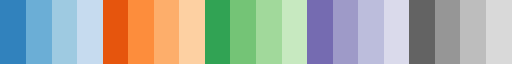

In [849]:
cm.tab20c

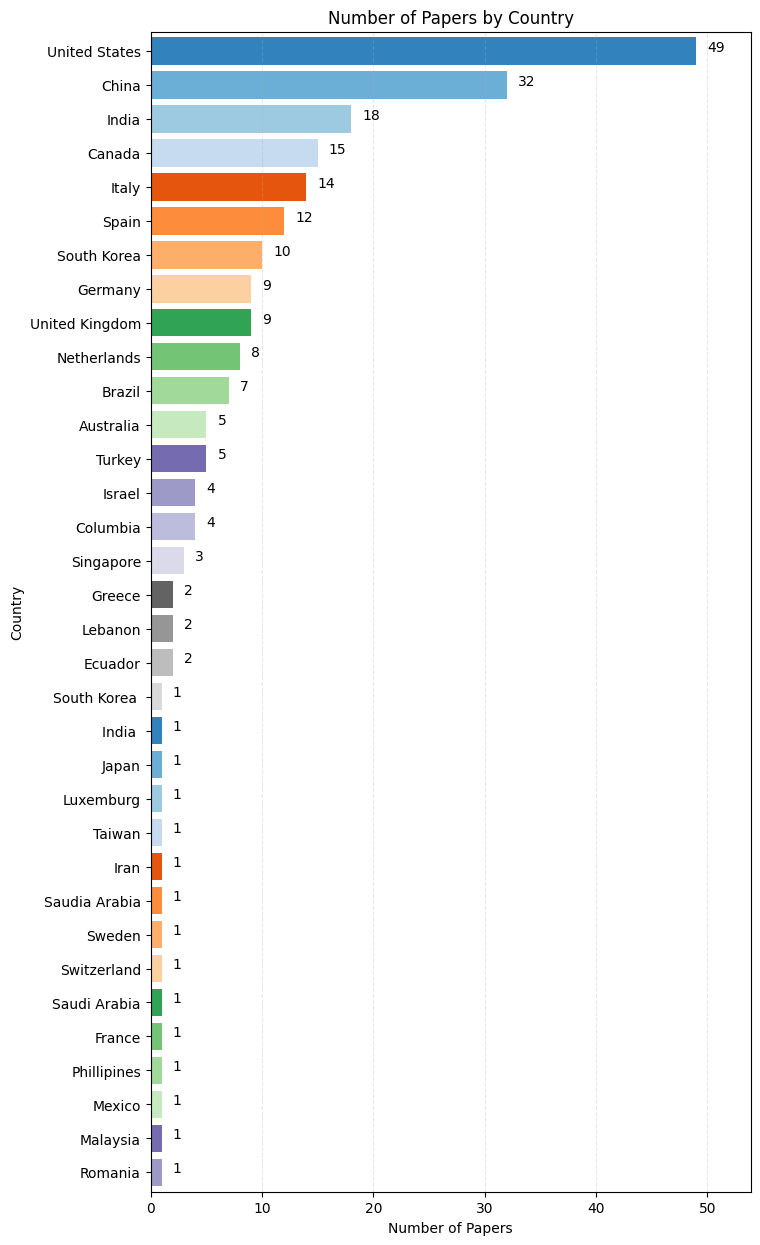

In [850]:
# Plot the horizontal bar graph with spacing between bars
country_counts = df['Country'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(country_counts.index, country_counts.values, color=cm.tab20c.colors[:len(country_counts)])
# Set the x-axis label
max_count = country_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Country')
plt.title('Number of Papers by Country')

for i, v in enumerate(country_counts.values):
        plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

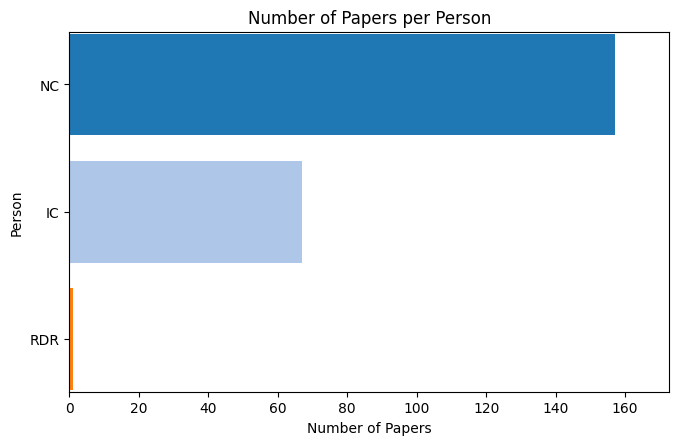

In [851]:
# Plot the horizontal bar graph with spacing between bars
person_counts = df['Person'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(person_counts.index, person_counts.values, color=cm.tab20.colors[:len(person_counts)])
# Set the x-axis label
max_count = person_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Person')
plt.title('Number of Papers per Person')

# for i, v in enumerate(person_counts.values):
#         plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=0.5, bottom=0.05)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

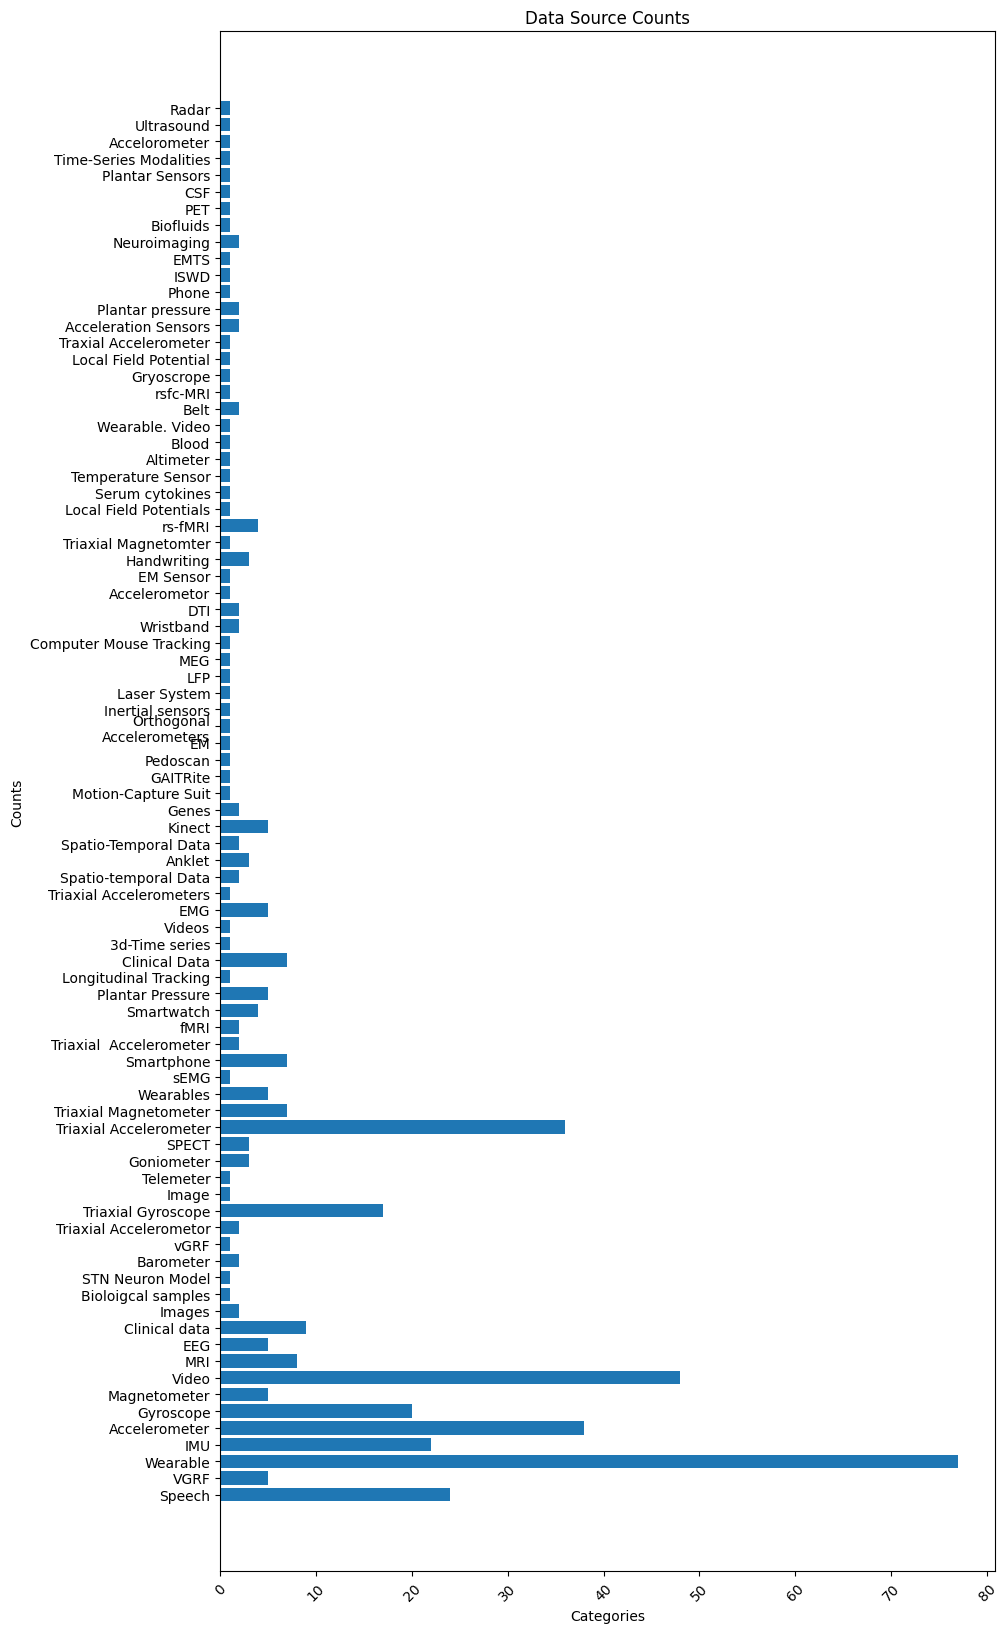

In [852]:
category_counts = GetCategoriesSum(df, "Data Source Secondary")

# Convert dictionary to Series for plotting
category_counts_series = pd.Series(category_counts)

# Plotting the bar chart
plt.figure(figsize=(10, 20))
plt.barh(category_counts_series.index, category_counts_series.values)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Data Source Counts')
plt.xticks(rotation=45)
plt.show()

In [853]:
#model = SentenceTransformer("all-MiniLM-L6-v2") # Change model to bio
#model2 = SentenceTransformer("../models/sentence-transformers/emilyalsentzer_Bio_ClinicalBERTo_ClinicalBERT")
#model2 = SentenceTransformer("monologg/biobert_v1.1_pubmed")

#tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
#model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

model = SentenceTransformer("pritamdeka/S-PubMedBert-MS-MARCO")
'''
- UMAP > t-SNE (better at preserving global structure & performance)
    - Higher n_neighbor --> more global structure
        - Higher noise, focus on large-scale trends
    - Lower min_dist --> tightly packed, highly distinguishable clusters, emphasizing local density.
        - Good for high-dimensional datasets where clusters are more continuous or overlapping.
        - Suitable when your clusters are discrete and well-separated in high-dimensional space.
        - Helpful for applications like classification tasks, where precise boundaries between clusters are desired.

'''

'\n- UMAP > t-SNE (better at preserving global structure & performance)\n    - Higher n_neighbor --> more global structure\n        - Higher noise, focus on large-scale trends\n    - Lower min_dist --> tightly packed, highly distinguishable clusters, emphasizing local density.\n        - Good for high-dimensional datasets where clusters are more continuous or overlapping.\n        - Suitable when your clusters are discrete and well-separated in high-dimensional space.\n        - Helpful for applications like classification tasks, where precise boundaries between clusters are desired.\n\n'

In [873]:
df["Paper"] = df["Paper"].fillna("")
embedded_papers = EmbedFrame(df, "Paper", model)
embedded_reduced_papers = ReduceEmbedding(embedded_papers, neighbors=100, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_papers, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_papers, num_clusters, "Reduced Paper Cluster")
VisualizeCluster(df, "Title", embedded_reduced_papers, "Reduced Paper Cluster")

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
df["Authors"] = df["Authors"].fillna("")
embedded_authors = EmbedFrame(df, "Authors", model)
embedded_reduced_authors = ReduceEmbedding(embedded_authors, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_authors, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_authors, num_clusters, "Reduced Authors Cluster")
VisualizeCluster(df, "Authors", embedded_reduced_authors, "Reduced Authors Cluster", show_authors=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [856]:
df["Abstract"] = df["Abstract"].fillna("")
embedded_abstracts = EmbedFrame(df, "Abstract", model)
embedded_reduced_abstracts = ReduceEmbedding(embedded_abstracts, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_abstracts, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_abstracts, num_clusters, "Reduced Abstract Cluster")
VisualizeCluster(df, "Abstract", embedded_reduced_abstracts, "Reduced Abstract Cluster")

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [887]:
df["Country"] = df["Country"].fillna("")
embedded_countries = EmbedFrame(df, "Country", model)
embedded_reduced_countries = ReduceEmbedding(embedded_countries, neighbors=12, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_countries, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_countries, num_clusters, "Reduced Country Cluster")
VisualizeCluster(df, "Country", embedded_reduced_countries, "Reduced Country Cluster", show_country=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [888]:
df["Data Source Secondary"] = df["Data Source Secondary"].fillna("")
embedded_dss = EmbedFrame(df, "Data Source Secondary", model)
embedded_reduced_dss = ReduceEmbedding(embedded_dss, neighbors=10, min_distance=.45)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_dss, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_dss, num_clusters, "Reduced Data Source Secondary Cluster")
VisualizeCluster(df, "Data Source Secondary", embedded_reduced_dss, "Reduced Data Source Secondary Cluster", show_data_source=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [889]:
df["Algorithm"] = df["Algorithm"].fillna("")
embedded_algorithms = EmbedFrame(df, "Algorithm", model)
embedded_reduced_algorithms = ReduceEmbedding(embedded_algorithms, neighbors=10, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_algorithms, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_algorithms, num_clusters, "Reduced Algorithm Cluster")
VisualizeCluster(df, "Algorithm", embedded_reduced_algorithms, "Reduced Algorithm Cluster", show_algorithm=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
df["Task"] = df["Task"].fillna("")
embedded_tasks = EmbedFrame(df, "Task", model)
embedded_reduced_tasks = ReduceEmbedding(embedded_tasks, neighbors=5, min_distance=.35)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_tasks, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_tasks, num_clusters, "Reduced Task Cluster")
VisualizeCluster(df, "Task", embedded_reduced_tasks, "Reduced Task Cluster", show_task=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
df["Cross Validation"] = df["Cross Validation"].fillna("")
embedded_cvs = EmbedFrame(df, "Cross Validation", model)
embedded_reduced_cvs = ReduceEmbedding(embedded_cvs, neighbors=500, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_cvs, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_cvs, num_clusters, "Reduced Cross Validation Cluster")
VisualizeCluster(df, "Cross Validation", embedded_reduced_cvs, "Reduced Cross Validation Cluster", show_cv=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



In [ ]:
df["Performance Metric"] = df["Performance Metric"].fillna("")
embedded_pms = EmbedFrame(df, "Performance Metric", model)
embedded_reduced_pms = ReduceEmbedding(embedded_pms, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_pms, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_pms, num_clusters, "Reduced Performance Metric Cluster")
VisualizeCluster(df, "Performance Metric", embedded_reduced_pms, "Reduced Performance Metric Cluster", show_performance_metric=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
''' TODO: Use Scatter Plot w/ Integers
df["Sample Size"] = df["Sample Size"].fillna("")

embedded_patient_count = EmbedFrame(df, "Patient Count", model)
embedded_control_count = EmbedFrame(df, "Control Count", model)

embedded_reduced_patient_count = ReduceEmbedding(embedded_patient_count, neighbors=50, min_distance=0)
embedded_reduced_control_count = ReduceEmbedding(embedded_control_count, neighbors=50, min_distance=0)

embedded_sample_size = np.concatenate((embedded_reduced_patient_count, embedded_reduced_control_count), axis=1)

optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_sample_size, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_sample_size, num_clusters, "Reduced Patient Count Cluster")
VisualizeCluster(df, "Patient Count", embedded_sample_size, "Reduced Patient Count Cluster")
'''

' TODO: Use Scatter Plot w/ Integers\ndf["Sample Size"] = df["Sample Size"].fillna("")\nFormatSampleSize(df)\n\nembedded_patient_count = EmbedFrame(df, "Patient Count", model)\nembedded_control_count = EmbedFrame(df, "Control Count", model)\n\nembedded_reduced_patient_count = ReduceEmbedding(embedded_patient_count, neighbors=50, min_distance=0)\nembedded_reduced_control_count = ReduceEmbedding(embedded_control_count, neighbors=50, min_distance=0)\n\nembedded_sample_size = np.concatenate((embedded_reduced_patient_count, embedded_reduced_control_count), axis=1)\n\noptimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend=\'joblib\')\nnum_clusters = optimalKObj(embedded_sample_size, n_refs=50, cluster_array=np.arange(1,10))\nCreateCluster(df, embedded_sample_size, num_clusters, "Reduced Patient Count Cluster")\nVisualizeCluster(df, "Patient Count", embedded_sample_size, "Reduced Patient Count Cluster")\n'

In [ ]:
#TODO: Write out full dataset acronym
df["Dataset"] = df["Dataset"].fillna("")
embedded_datasets = EmbedFrame(df, "Dataset", model)
embedded_reduced_datasets = ReduceEmbedding(embedded_datasets, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_datasets, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_datasets, num_clusters, "Reduced Dataset Cluster")
VisualizeCluster(df, "Dataset", embedded_reduced_datasets, "Reduced Dataset Cluster", show_dataset=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [891]:
df["Goal"] = df["Goal"].fillna("")
embedded_goals = EmbedFrame(df, "Goal", model)
embedded_reduced_goals = ReduceEmbedding(embedded_goals, neighbors=2, min_distance=.5)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_goals, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_goals, num_clusters, "Reduced Goal Cluster")
VisualizeCluster(df, "Goal", embedded_reduced_goals, "Reduced Goal Cluster", show_goal=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [900]:
df["Wearable Location"] = df["Wearable Location"].fillna("")
embedded_wearable_locs = EmbedFrame(df, "Wearable Location", model)
embedded_reduced_wearable_locs = ReduceEmbedding(embedded_wearable_locs, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_wearable_locs, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_wearable_locs, num_clusters, "Reduced Wearable Location Cluster")
VisualizeCluster(df, "Wearable Location", embedded_reduced_wearable_locs, "Reduced Wearable Location Cluster", show_wearable=True)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [867]:
 # High Dimensionality, beneficial if each feature captures unique and important data, diluted distance

embedding_list = [     
    embedded_authors,
    embedded_reduced_wearable_locs,
    embedded_reduced_tasks,
    embedded_reduced_datasets,
    embedded_reduced_papers,
    embedded_reduced_dss,
    embedded_reduced_goals,
    embedded_reduced_abstracts,
    embedded_reduced_countries,
    embedded_reduced_algorithms,
    embedded_reduced_cvs,
    embedded_reduced_pms
]

high_dimensionality_embeddings = np.concatenate(embedding_list, axis=1)

embedded_reduced_high_dim= ReduceEmbedding(high_dimensionality_embeddings, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_high_dim, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_high_dim, num_clusters, "Reduced High Dimenstionality Total Cluster")
VisualizeCluster(df, "Reduced High Dimenstionality", embedded_reduced_high_dim, "Reduced High Dimenstionality Total Cluster")

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



In [868]:
# Can use "memory" of previous clusters by column + all base data
# Captures patterns throughout features, but may dilute the importance of individual features - distances are more meaningful - 
df["Low Dimensionality Total"] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df["Low Dimensionality Total"] = df["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality = EmbedFrame(df, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality = ReduceEmbedding(embedded_low_dimensionality, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_low_dimensionality, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_low_dimensionality, num_clusters, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df, "Low Dimensionality Total", embedded_reduced_low_dimensionality, "Reduced Low Dimensionality Total Cluster")

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [869]:
print(df.columns)
df = df.drop('Reduced Paper Cluster', axis=1)
df = df.drop('Reduced Authors Cluster', axis=1)
df = df.drop('Reduced Abstract Cluster', axis=1)
df = df.drop('Reduced Country Cluster', axis=1)
df = df.drop('Reduced Data Source Secondary Cluster', axis=1)
df = df.drop('Reduced Algorithm Cluster', axis=1)
df = df.drop('Reduced Task Cluster', axis=1)
df = df.drop('Reduced Cross Validation Cluster', axis=1)
df = df.drop('Reduced Performance Metric Cluster', axis=1)
df = df.drop('Reduced Dataset Cluster', axis=1)
df = df.drop('Reduced Goal Cluster', axis=1)
df = df.drop('Reduced Wearable Location Cluster', axis=1)
df = df.drop('Reduced High Dimenstionality Total Cluster', axis=1)


Index(['Authors', 'Year', 'Paper', 'Country', 'MDS', 'Data Source Primary',
       'Data Source Secondary', 'Algorithm', 'Task', 'Cross Validation',
       'Performance Metric', 'Sample Size', 'Dataset', 'Goal', 'Abstract',
       'Person', 'Notes', 'Wearable Location', 'MDS Simplified',
       'Reduced Paper Cluster', 'Reduced Authors Cluster',
       'Reduced Abstract Cluster', 'Reduced Country Cluster',
       'Reduced Data Source Secondary Cluster', 'Reduced Algorithm Cluster',
       'Reduced Task Cluster', 'Reduced Cross Validation Cluster',
       'Reduced Performance Metric Cluster', 'Reduced Dataset Cluster',
       'Reduced Goal Cluster', 'Reduced Wearable Location Cluster',
       'Reduced High Dimenstionality Total Cluster',
       'Low Dimensionality Total', 'Reduced Low Dimensionality Total Cluster'],
      dtype='object')


In [870]:
# Does not have "memory" of previous clusters + all base data
df["Low Dimensionality Total"] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df["Low Dimensionality Total"] = df["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality = EmbedFrame(df, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality = ReduceEmbedding(embedded_low_dimensionality, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_low_dimensionality, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_low_dimensionality, num_clusters, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df, "Low Dimensionality Total", embedded_reduced_low_dimensionality, "Reduced Low Dimensionality Total Cluster")

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
#TODO: Review Above Graphs for most consequential/separate clusters and adjust weights accordingly
weights = [
    0.0,  # Weight for embedded_authors
    0.0,  # Weight for embedded_reduced_wearable_locs
    0.0,  # Weight for embedded_reduced_tasks
    0.0,  # Weight for embedded_reduced_datasets
    0.0,  # Weight for embedded_reduced_papers
    0.0,  # Weight for embedded_reduced_dss
    0.0,  # Weight for embedded_reduced_goals
    1.0,  # Weight for embedded_reduced_abstracts
    0.0,  # Weight for embedded_reduced_countries
    0.0,  # Weight for embedded_reduced_algorithms
    0.0,  # Weight for embedded_reduced_cvs
    0.0,  # Weight for embedded_reduced_pms
]

embedding_list = [
    embedded_authors,
    embedded_reduced_wearable_locs,
    embedded_reduced_tasks,
    embedded_reduced_datasets,
    embedded_reduced_papers,
    embedded_reduced_dss,
    embedded_reduced_goals,
    embedded_reduced_abstracts,
    embedded_reduced_countries,
    embedded_reduced_algorithms,
    embedded_reduced_cvs,
    embedded_reduced_pms
]

weighted_embeddings = [embedding * weight for embedding, weight in zip(embedding_list, weights)]

weighted_embeddings = [embedding for embedding in weighted_embeddings if not np.all(embedding == 0)]

if len(weighted_embeddings) > 1:
    high_dimensionality_embeddings = np.concatenate(weighted_embeddings, axis=1)
elif len(weighted_embeddings) == 1:
    high_dimensionality_embeddings = weighted_embeddings[0]
else:
    raise ValueError("All weights are zero. Please assign a non-zero weight to at least one embedding.")

embedded_reduced_high_dim = ReduceEmbedding(high_dimensionality_embeddings, neighbors=50, min_distance=0)

optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_high_dim, n_refs=50, cluster_array=np.arange(1, 10))

CreateCluster(df, embedded_reduced_high_dim, num_clusters, "Adjusted Weighted Cluster")
VisualizeCluster(df, "Adjusted Weighted Embeddings", embedded_reduced_high_dim, "Adjusted Weighted Cluster")


c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

